In [15]:
import numpy as np
import pandas as pd
import tensorflow
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlp import MLP
from processing import make_shifts
from metrics import all_metrics_from_dataframes, mse

In [6]:
df = pd.read_csv('australia.csv')

In [7]:
LAGS = 5
HORIZONS = 12
CENTRAL = 'KIATAWF1'
INITS = 1 
HIDDEN_LAYERS = [10,5]
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mse'
VALIDATION_SPLIT = 0.2
EPOCHS = 200

serie = df[CENTRAL]

train, test = train_test_split(serie, test_size=.66, shuffle=False)
X_train, Y_train = make_shifts(train, LAGS, HORIZONS, dropnan=True)
X_test, Y_test = make_shifts(test, LAGS, HORIZONS, dropnan=False)

In [13]:
model = MLP(n_horizons=HORIZONS, n_inits=INITS)
model.build(hidden_layers=HIDDEN_LAYERS, input_size=LAGS, activation=ACTIVATION, optimizer=OPTIMIZER, loss=LOSS)
model.train(X_train.values, Y_train.values, validation_split=VALIDATION_SPLIT, epochs=EPOCHS)
pred = model.predict(X_test.values)
pred

===============] - 1s 810us/step - loss: 22.3919 - val_loss: 21.1701
Epoch 15/200
894/894 [==============================] - 1s 844us/step - loss: 22.3921 - val_loss: 21.1346
Epoch 16/200
894/894 [==============================] - 1s 839us/step - loss: 22.3367 - val_loss: 21.1021
Epoch 17/200
894/894 [==============================] - 1s 812us/step - loss: 22.3465 - val_loss: 21.0830
Epoch 18/200
894/894 [==============================] - 1s 813us/step - loss: 22.3421 - val_loss: 21.1410
Epoch 19/200
894/894 [==============================] - 1s 797us/step - loss: 22.3561 - val_loss: 21.1225
Epoch 20/200
894/894 [==============================] - 1s 815us/step - loss: 22.3507 - val_loss: 21.1079
Epoch 21/200
894/894 [==============================] - 1s 836us/step - loss: 22.3462 - val_loss: 21.0139
Epoch 22/200
894/894 [==============================] - 1s 846us/step - loss: 22.3365 - val_loss: 21.2319
Epoch 23/200
894/894 [==============================] - 1s 820us/step - loss: 22.37

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.813238,25.431553,25.326797,25.121925,25.079206,24.562990,24.684019,24.305510,24.504036,24.103048,24.347469,23.166290
...,...,...,...,...,...,...,...,...,...,...,...,...
69375,15.150370,14.857852,14.955338,14.928103,14.835406,14.919021,14.639254,14.976210,14.820783,15.155188,15.306470,14.400490
69376,16.193178,16.063290,16.026148,15.894288,15.819097,16.027910,15.792539,16.011251,15.736903,16.216623,16.332703,15.759537
69377,22.072002,22.330067,22.000202,21.403130,21.992609,21.526499,21.681271,21.405886,21.924454,21.314503,21.368513,21.601086
69378,23.594267,22.991030,23.217443,23.252813,22.882137,22.527231,22.541683,22.525723,22.976807,22.451920,22.226898,23.470932


In [14]:
all_metrics_from_dataframes(pred, Y_test)

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
mse,3.542018,6.179062,8.514427,10.662243,12.757167,14.630759,16.355979,17.976312,19.646678,21.503861,22.677647,24.995655
rmse,1.882025,2.485772,2.917949,3.265309,3.571718,3.825018,4.044253,4.239848,4.432457,4.637226,4.762105,4.999565
bias,0.016730,-0.085039,-0.125838,-0.129036,-0.257329,-0.363312,-0.212539,-0.351566,-0.296384,-0.316465,-0.165118,-0.584875
mae,1.046540,1.486883,1.811605,2.084365,2.338683,2.577999,2.735731,2.962794,3.096731,3.287270,3.386896,3.667178
mape,0.419718,0.611670,0.636935,1.360642,1.219928,1.278664,0.905636,0.429468,0.446330,0.528443,0.439206,0.485555
corr_coef,0.985768,0.975076,0.965527,0.956633,0.948107,0.940585,0.932845,0.926626,0.919046,0.911200,0.905663,0.897760
std_ratio,0.987359,0.969973,0.957630,0.946654,0.934582,0.920466,0.913781,0.893377,0.892035,0.878117,0.874301,0.845595
rmsd,1.881946,2.484329,2.915246,3.262768,3.562456,3.807752,4.038680,4.225270,4.422552,4.626425,4.759245,4.965245
ss4,0.059008,0.056446,0.054216,0.052186,0.050272,0.048584,0.046946,0.045498,0.044013,0.042367,0.041299,0.039480


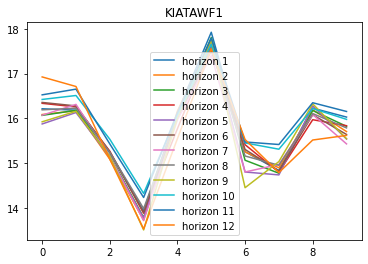

In [25]:
for h in range(1,HORIZONS+1):
    plt.plot(pred[f't+{h}'].values[100:110], label=f'horizon {h}')
plt.legend()
plt.title(CENTRAL)
plt.show()

In [16]:
Y_test

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
35740,29.8,25.1,25.9,25.8,25.3,26.0,25.3,27.0,26.5,26.3,25.7,27.9
35741,25.1,25.9,25.8,25.3,26.0,25.3,27.0,26.5,26.3,25.7,27.9,29.2
35742,25.9,25.8,25.3,26.0,25.3,27.0,26.5,26.3,25.7,27.9,29.2,28.5
35743,25.8,25.3,26.0,25.3,27.0,26.5,26.3,25.7,27.9,29.2,28.5,29.2
35744,25.3,26.0,25.3,27.0,26.5,26.3,25.7,27.9,29.2,28.5,29.2,29.5
...,...,...,...,...,...,...,...,...,...,...,...,...
105115,16.4,23.3,24.0,24.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105116,23.3,24.0,24.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105117,24.0,24.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105118,24.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
X_train.values

array([[29.2, 28.8, 28.4, 28. , 28.3],
       [28.8, 28.4, 28. , 28.3, 28.5],
       [28.4, 28. , 28.3, 28.5, 27.5],
       ...,
       [29.4, 25.6, 25.6, 25.6, 25.5],
       [25.6, 25.6, 25.6, 25.5, 25.6],
       [25.6, 25.6, 25.5, 25.6, 25.5]])

In [18]:
Y_train.values

array([[28.5, 27.5, 26.6, ..., 17.7, 15.8, 16.9],
       [27.5, 26.6, 26.6, ..., 15.8, 16.9, 17.8],
       [26.6, 26.6, 26.9, ..., 16.9, 17.8, 18. ],
       ...,
       [25.6, 25.5, 25.3, ..., 29.1, 29.6, 29.7],
       [25.5, 25.3, 24.4, ..., 29.6, 29.7, 29.8],
       [25.3, 24.4, 29.2, ..., 29.7, 29.8, 29.8]])